In [1]:
# Preliminaries
%matplotlib inline
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
# 1. Load data
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [13]:
# Check data
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [11]:
train_data[10]

array([  9.59571,   0.     ,  18.1    ,   0.     ,   0.693  ,   6.404  ,
       100.     ,   1.639  ,  24.     , 666.     ,  20.2    , 376.11   ,
        20.31   ])

In [63]:
# Normalize the data
mean = train_data.mean(axis=0)
print('mean: ',mean)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

mean:  [ 7.83201886e-18  7.36484581e-17  1.48396147e-17  1.18991725e-16
  5.60607666e-17 -3.11906716e-17  1.09923072e-17  6.48546123e-17
  1.95113452e-17 -7.69461502e-17 -2.85799987e-17  3.89539885e-17
 -1.20915379e-17]


In [15]:
train_data[10]

array([ 0.63391647, -0.48361547,  1.0283258 , -0.25683275,  1.15788777,
        0.19313958,  1.11048828, -1.03628262,  1.67588577,  1.5652875 ,
        0.78447637,  0.22689422,  1.04466491])

In [16]:
# Build the model/network
def build_model():
    # Because we need to instantiate
    # the same model multiple times
    # we use function to construct it
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

In [40]:
"""
# k-fold cross validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae = []
for i in range(k):
    print(f'processing fold #{i}')
    # prepare the validation data: data from partition # k
    val_data = train_data[num_val_samples * i: num_val_samples * (i+1)]
    val_targets = train_targets[num_val_samples * i: num_val_samples * (i+1)]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        (train_data[:num_val_samples * i],
        train_data[num_val_samples * (i+1):]),
        axis=0)
    # print(partial_train_data.shape)
    # print(val_data.shape)
    partial_train_targets = np.concatenate(
        (train_targets[:num_val_samples * i],
        train_targets[num_val_samples * (i+1):]),
        axis=0)
    
    # build the keras model; already compiled
    model = build_model()
    # train the model in silent mode (verbose=0)
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0)
    # evaluate the model on validation data
    mse, mae = model.evaluate(val_data, val_targets, verbose=0)
    all_mae.append(mae)

"""
# k-fold cross validation; saving validation logs at each fold
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"processing fold #: {i}")
    # preparing validation data: data from partition # k
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    # preparing training data: data from all other partitions
    partial_train_data = np.concatenate(
        (train_data[: i*num_val_samples], 
        train_data[(i+1)*num_val_samples:]),
        axis=0)
    partial_train_targets = np.concatenate(
        (train_targets[: i*num_val_samples], train_targets[(i+1)*num_val_samples:]),
        axis=0)
    
    # build the keras model (already compiled)
    model = build_model()
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        epochs=num_epochs, 
                        batch_size=1,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    #print(f"history keys: {history.history.keys()}")
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    


processing fold #: 0
history keys: dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])
processing fold #: 1
history keys: dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])
processing fold #: 2
history keys: dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])
processing fold #: 3
history keys: dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


In [43]:
len(all_mae_histories), len(all_mae_histories[0])

(4, 500)

In [45]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
len(avg_mae_history)

500

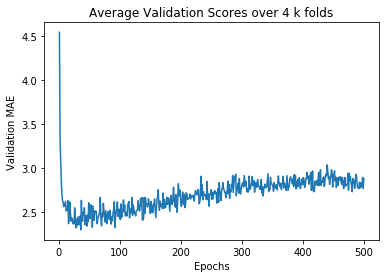

In [47]:
# Plotting validation scores
plt.plot(range(1, len(avg_mae_history)+1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Average Validation Scores over 4 folds')

plt.show()

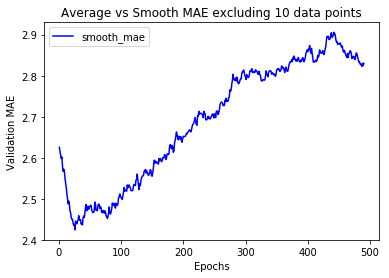

In [50]:
# The above graph is hard to visualize 
# because of scaling issue and high variance
# so let's remove the first 10 data points 
# which are on different scale

# 'Raw data points' vs 'Exponential moving average for smooth curve'
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# excluding first 10 data points
smooth_mae_history = smooth_curve(avg_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history, 'b', label='smooth_mae')
#plt.plot(range(1, len(smooth_mae_history) + 1), avg_mae_history[10:], 'r', label='avg_mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Average vs Smooth MAE excluding 10 data points')
plt.legend()

plt.show()


In [61]:
# After 80 epochs the model starts overfitting
# Training the final model with full train_data

model = build_model()
history = model.fit(train_data,
          train_targets,
          epochs=80,
          batch_size=16,
          verbose=0)

print('Train mae',np.mean(history.history['mean_absolute_error']))
# evaluating the model on test data
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
# our final result
test_mae_score

Train mae 2.732780727419523
102/102 [==============================] - 0s 2ms/step


2.781857817780738

In [ ]:
# We are still off by appx. $2,600